In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
#Batch size
batch_size=128
#Epoch 
num_epochs=3
#learning rate
learning_rate=0.001

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),    # Data Aumentation
        transforms.RandomHorizontalFlip(),    # Data Augmentation, 좌우 대칭
        transforms.ToTensor(),                # 기본 data transform, Data Augmentation 후에 작성
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])   # mean, std  # 기본 data transform, Data Augmentation 후에 작성
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_set=torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms['train'])
test_set =torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms['val'])

dataloaders=dict()   # 학습 진행 하면서/infer 하면서 data를 batch에 따라 나누고, shuffle하는 것
dataloaders['train']= torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
dataloaders['val']= torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

print("train 개수",dataset_sizes['train'])
print("test 개수",dataset_sizes['val'])

class_names = train_set.classes   # class 확인 가능
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("class_names:",class_names)
print(device)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train 개수 50000
test 개수 10000
class_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cuda:0


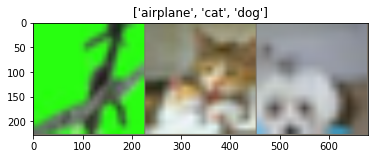

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#batch가 너무 크면 다 안보이니 3개만 가져오기
inputs_=inputs[:3]
classes_=classes[:3]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs_)

imshow(out, title=[class_names[x] for x in classes_])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()   # 모델 학습 시간 측정을 위함

    best_model_wts = copy.deepcopy(model.state_dict())  # 모델의 가중치 등의 정보 가져옴
    best_acc = 0.0   # 모델의 최고의 성능의 가중치를 저장하기 위해 최고 성능 저장

    train_loss_list=[]
    val_acc_list=[]

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            iteration_count=0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:  # Batch
                iteration_count+=len(inputs)
                print('Iteration {}/{}'.format(iteration_count,dataset_sizes[phase]))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)           # 모델에 input을 넣어 줌
                    _, preds = torch.max(outputs, 1)  # 가장 prediction score가 가장 높은 값의 인덱스가 저장됨
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()   # 미분값 계산
                        optimizer.step()  # 가중치 갱신

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase=="train":
              train_loss_list.append(epoch_loss)
            elif phase=="val":
              val_acc_list.append(epoch_acc)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss_list,val_acc_list

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
# 모델 Load하기
model_ft = models.vgg16(pretrained=True)        # imagenet으로 사전 학습된 가중치 불러옴
# imagenet이 아닌 cifar-10에 해당하는 classification을 위해 모델의 맨 마지막 layer 조정(바꿔줌)
num_ftrs = model_ft.classifier[6].in_features   
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))
# device에 모델을 올려주겠다. -> gpu에 모델이 올라감
model_ft = model_ft.to(device)
print(model_ft)   # 모델의 정보

# Loss Function 설정
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#SGD
optimizer_ft = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=0.9)
#Adam
# optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs   // Learning Rate를 몇 에폭마다 조금씩 줄여주겠다. 기존_lr * gamma
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [8]:
model_ft,train_loss_list,val_acc_list = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/2
----------
Iteration 128/50000


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Iteration 256/50000
Iteration 384/50000
Iteration 512/50000
Iteration 640/50000
Iteration 768/50000
Iteration 896/50000
Iteration 1024/50000
Iteration 1152/50000
Iteration 1280/50000
Iteration 1408/50000
Iteration 1536/50000
Iteration 1664/50000
Iteration 1792/50000
Iteration 1920/50000
Iteration 2048/50000
Iteration 2176/50000
Iteration 2304/50000
Iteration 2432/50000
Iteration 2560/50000
Iteration 2688/50000
Iteration 2816/50000
Iteration 2944/50000
Iteration 3072/50000
Iteration 3200/50000
Iteration 3328/50000
Iteration 3456/50000
Iteration 3584/50000
Iteration 3712/50000
Iteration 3840/50000
Iteration 3968/50000
Iteration 4096/50000
Iteration 4224/50000
Iteration 4352/50000
Iteration 4480/50000
Iteration 4608/50000
Iteration 4736/50000
Iteration 4864/50000
Iteration 4992/50000
Iteration 5120/50000
Iteration 5248/50000
Iteration 5376/50000
Iteration 5504/50000
Iteration 5632/50000
Iteration 5760/50000
Iteration 5888/50000
Iteration 6016/50000
Iteration 6144/50000
Iteration 6272/5000

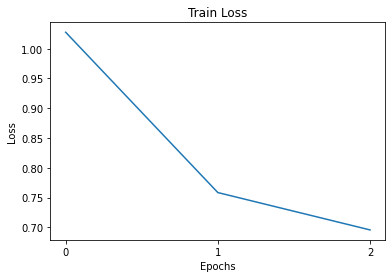

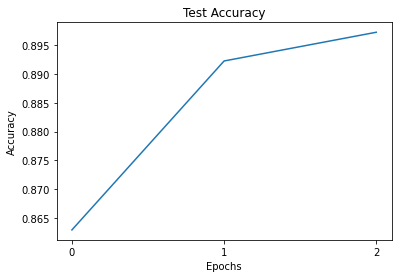

In [9]:
#plot train loss 
x=[i for i in range(0,num_epochs)]
plt.title("Train Loss")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x,train_loss_list)
plt.show()

#plot test acc
x=[i for i in range(0,num_epochs)]
plt.title("Test Accuracy")
plt.xticks(x)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(x,val_acc_list)
plt.show()

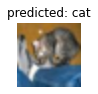

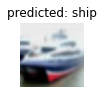

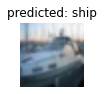

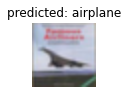

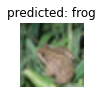

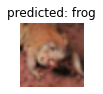

In [10]:
visualize_model(model_ft)